In [1]:
import pandas as pd
import altair as alt
alt.renderers.enable('mimetype')
%matplotlib inline

# produce vector inline graphics
from IPython.display import set_matplotlib_formats, display, Markdown, HTML

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 4]
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/shubham13p/Ad-Click-Prediction/master/advertising.csv')
df['Click_labeled'] = df['Clicked on Ad'].apply(lambda x: "Click" if x == 1 else "No Click")
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Click_labeled
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,No Click
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,No Click
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,No Click
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,No Click
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,No Click


## Topic Modeling


Here, we will try to get relevant topics from the ad text.

We'll use Non-negative Matrix Factorization (NMF) to split the ad text into 3 topics.

In [3]:
tfidf_vect = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
doc_term_matrix = tfidf_vect.fit_transform(df['Ad Topic Line'].values.astype('U'))


In [4]:
nmf = NMF(n_components=3, random_state=42)
nmf.fit(doc_term_matrix )

topic_values = nmf.transform(doc_term_matrix)
df['Topic'] = topic_values.argmax(axis=1)

In [5]:
nmf_components = nmf.components_
feature_names = tfidf_vect.get_feature_names_out()

divs = []

for i,topic in enumerate(nmf.components_):
    

    num_ads = len(df[df['Topic']==i])
    top_5 = [feature_names[i] for i in topic.argsort()[-5:]]  
    top = ''.join([f'* {word} \n' for word in  top_5])

    markdown = f'''<div style="width: 33%; float: left;"> 
    
### Topic #{i+1}

**Number of Ads in Topic:** {num_ads}

{top}

</div>
''' 
    
    divs.append(markdown)
    
display(Markdown(''.join(divs)))

<div style="width: 33%; float: left;"> 
    
### Topic #1

**Number of Ads in Topic:** 649

* customer 
* solution 
* based 
* oriented 
* focused 


</div>
<div style="width: 33%; float: left;"> 
    
### Topic #2

**Number of Ads in Topic:** 155

* structure 
* interface 
* user 
* state 
* multi 


</div>
<div style="width: 33%; float: left;"> 
    
### Topic #3

**Number of Ads in Topic:** 196

* configurable 
* desk 
* thinking 
* secured 
* line 


</div>


### Topics and click rate


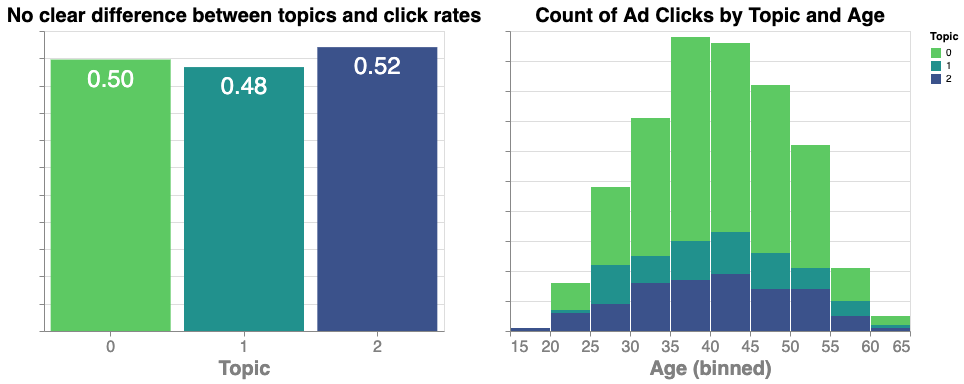

In [6]:
base = (alt.Chart(df, width=400).mark_bar()
 .encode(
     x=alt.X('Topic:N', axis=alt.Axis(labelAngle=0,
                                        labelFontSize=16,
                                        titleFontSize=20,
                                        labelColor='gray',
                                        titleColor='gray')),
     y=alt.Y('mean(Clicked on Ad)', axis=alt.Axis(labels=False, title='')))
 
 .properties(title='No clear difference between topics and click rates'))


bars = base.encode(color=alt.Color('Topic:N', 
                         scale=alt.Scale(scheme='viridis', reverse=True)))

text = base.mark_text(
    align='center',
    baseline='middle',
    dy=20,
    color='white',
    size=24
).encode(
    text=alt.Text('mean(Clicked on Ad):O', format=('.2f'))
)

topic_age = (alt.Chart(df[df['Clicked on Ad']==True], width=400).mark_bar()
 .encode(
     x=alt.X('Age:Q', bin=True, axis=alt.Axis(labelAngle=0,
                                        labelFontSize=16,
                                        titleFontSize=20,
                                        labelColor='gray',
                                        titleColor='gray')),
     y=alt.Y('count()', axis=alt.Axis(labels=False, title='')),
     color=alt.Color('Topic:N', 
                         scale=alt.Scale(scheme='viridis', reverse=True)))
 
 .properties(title='Count of Ad Clicks by Topic and Age'))



((bars + text ) | topic_age).configure_title(fontSize=20)